Analyzing class distribution... This may take a moment.


Processing classes: 100%|██████████| 38/38 [00:00<00:00, 949.22it/s]


--- Data Analysis Report ---
                                           Class Name  Image Count
0                                  Apple | Apple_scab         2016
1                                   Apple | Black_rot         1987
2                            Apple | Cedar_apple_rust         1760
3                                     Apple | healthy         2008
4                                 Blueberry | healthy         1816
5            Cherry_(including_sour) | Powdery_mildew         1683
6                   Cherry_(including_sour) | healthy         1826
7   Corn_(maize) | Cercospora_leaf_spot Gray_leaf_...         1642
8                         Corn_(maize) | Common_rust_         1907
9                 Corn_(maize) | Northern_Leaf_Blight         1908
10                             Corn_(maize) | healthy         1859
11                                  Grape | Black_rot         1888
12                       Grape | Esca_(Black_Measles)         1920
13         Grape | Leaf_blight_(


/tmp/ipykernel_5408/1652636441.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Image Count', y='Class Name', data=df_counts.sort_values(by='Image Count', ascending=False), palette='viridis')


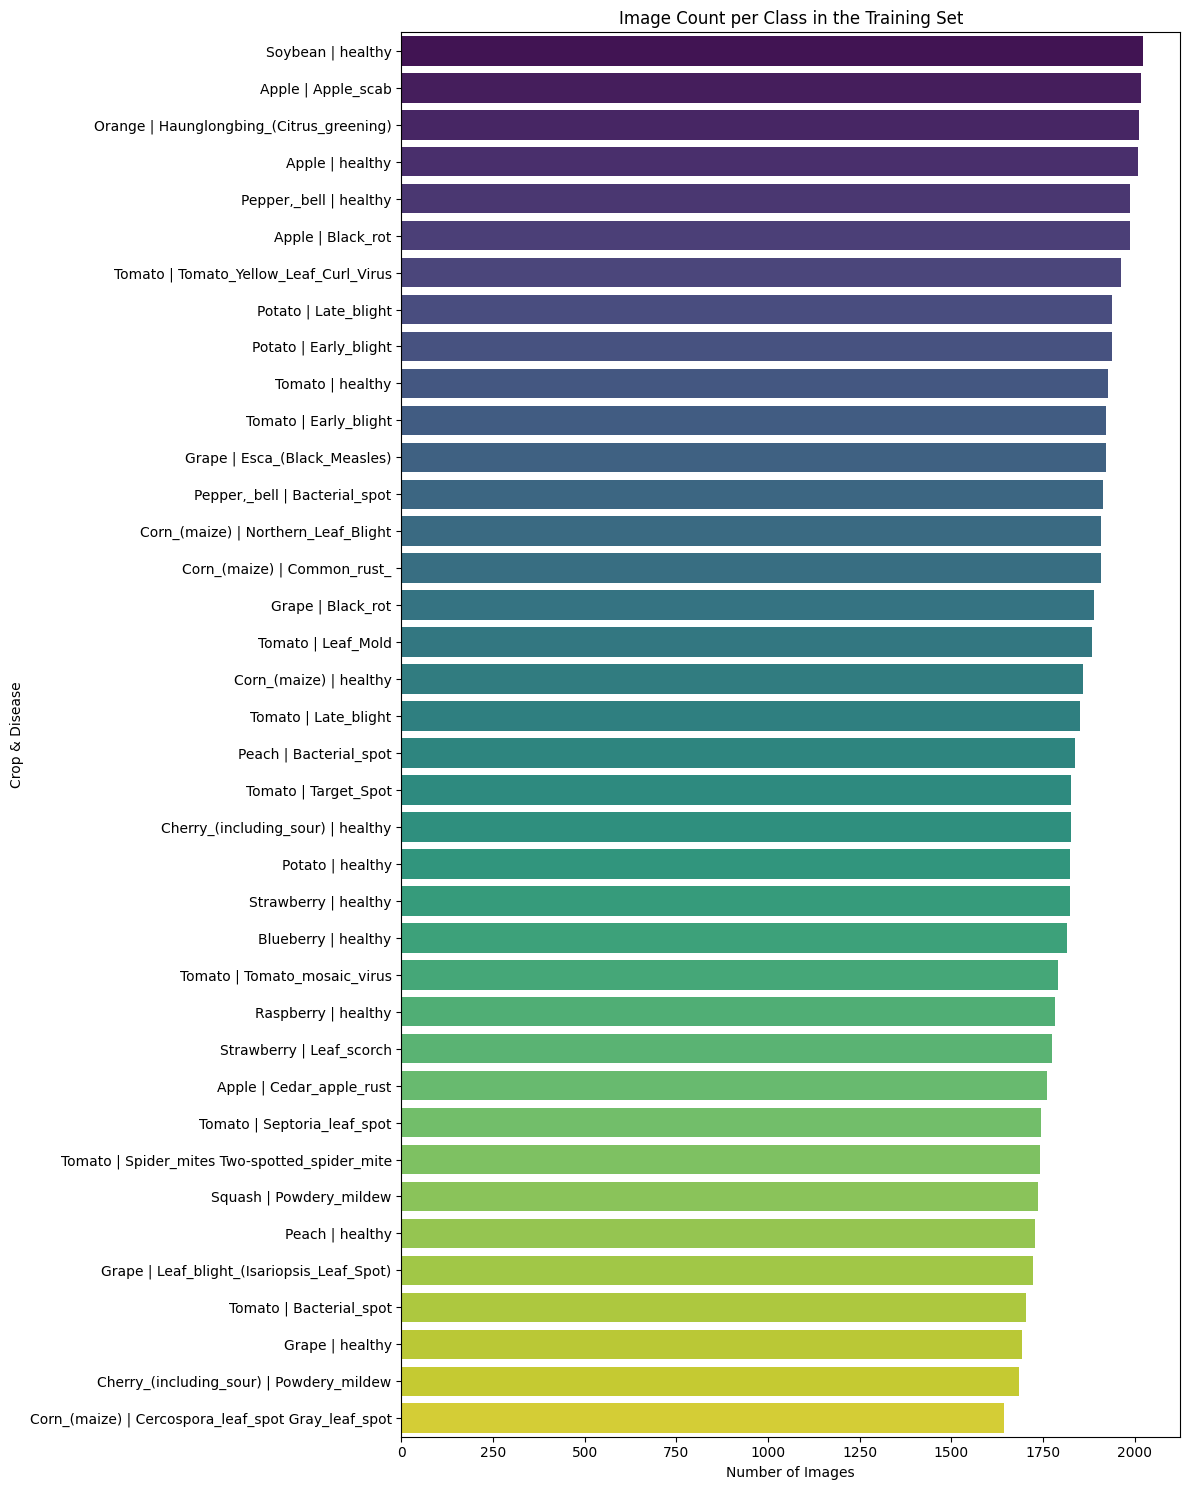

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

train_dir = 'Data/train'

if not os.path.isdir(train_dir):
    print(f"Error: Directory not found at '{train_dir}'")
else:
    class_counts = []
    print("Analyzing class distribution... This may take a moment.")
    
    classes = sorted(os.listdir(train_dir))
    
    for class_name in tqdm(classes, desc="Processing classes"):
        class_path = os.path.join(train_dir, class_name)
        if os.path.isdir(class_path):
            num_images = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            class_counts.append({'Class Name': class_name.replace('___', ' | '), 'Image Count': num_images})

    df_counts = pd.DataFrame(class_counts)

    print("\n--- Data Analysis Report ---")
    print(df_counts)
    plt.figure(figsize=(12, 15))
    sns.barplot(x='Image Count', y='Class Name', data=df_counts.sort_values(by='Image Count', ascending=False), palette='viridis')
    plt.title('Image Count per Class in the Training Set')
    plt.xlabel('Number of Images')
    plt.ylabel('Crop & Disease')
    plt.tight_layout()
    plt.show()

In [2]:
import torchvision.models as models
import torch.nn as nn

model = models.resnet50(weights='IMAGENET1K_V2')

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, 38)

print("Model setup complete. The new final layer is:")
print(model.fc)

Model setup complete. The new final layer is:
Linear(in_features=2048, out_features=38, bias=True)


In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
train_dir = 'Data/train'
valid_dir = 'Data/valid' 

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_dataset = datasets.ImageFolder(valid_dir, transform=valid_transforms)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)

print("DataLoaders created successfully!")
print(f"Found {len(train_dataset.classes)} classes in the training data.")

DataLoaders created successfully!
Found 38 classes in the training data.


In [4]:
import torch
import torch.optim as optim
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

NUM_EPOCHS = 5
for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    model.train() 
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * inputs.size(0)

    model.eval()
    running_val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad(): 
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
        
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    epoch_val_loss = running_val_loss / len(valid_loader.dataset)
    epoch_val_accuracy = 100 * correct_predictions / total_predictions
    
    epoch_duration = time.time() - start_time
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
          f"Train Loss: {epoch_train_loss:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} | "
          f"Val Acc: {epoch_val_accuracy:.2f}% | "
          f"Duration: {epoch_duration:.2f}s")

print("\n--- Training Complete ---")

Using device: cuda
Epoch 1/5 | Train Loss: 0.8524 | Val Loss: 0.4374 | Val Acc: 89.33% | Duration: 487.76s
Epoch 2/5 | Train Loss: 0.4264 | Val Loss: 0.3711 | Val Acc: 90.37% | Duration: 448.53s
Epoch 3/5 | Train Loss: 0.3553 | Val Loss: 0.3214 | Val Acc: 90.93% | Duration: 448.61s
Epoch 4/5 | Train Loss: 0.3267 | Val Loss: 0.2949 | Val Acc: 91.43% | Duration: 451.86s
Epoch 5/5 | Train Loss: 0.3019 | Val Loss: 0.2907 | Val Acc: 91.03% | Duration: 446.81s

--- Training Complete ---


In [5]:
import torch

SAVE_PATH = 'crop_disease_model_weights.pth'

torch.save(model.state_dict(), SAVE_PATH)

print(f"Model weights saved successfully to {SAVE_PATH}!")

Model weights saved successfully to crop_disease_model_weights.pth!


In [12]:
import os
import torch
from PIL import Image
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

test_dir = 'Data/test'

class_names = [
    'Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy',
    'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew',
    'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
    'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy',
    'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
    'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot',
    'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy',
    'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy',
    'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy',
    'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold',
    'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite',
    'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
    'Tomato___Tomato_mosaic_virus', 'Tomato___healthy'
]

valid_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


print("--- Running Predictions on Test Images ---")
image_files = sorted([f for f in os.listdir(test_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

for image_name in image_files:
    image_path = os.path.join(test_dir, image_name)
    try:
        img = Image.open(image_path).convert('RGB')
        
        tensor = valid_transforms(img).unsqueeze(0)
        
        tensor = tensor.to(device)
        
        with torch.no_grad():
            outputs = model(tensor)
            _, predicted_idx = torch.max(outputs, 1)
        
        predicted_class_name = class_names[predicted_idx.item()]
        
        # Print the result
        print(f"File: {image_name:<30} -> Predicted: {predicted_class_name}")

    except Exception as e:
        print(f"Could not process {image_name}. Reason: {e}")

--- Running Predictions on Test Images ---
File: AppleCedarRust1.JPG            -> Predicted: Apple___Cedar_apple_rust
File: AppleCedarRust2.JPG            -> Predicted: Apple___Cedar_apple_rust
File: AppleCedarRust3.JPG            -> Predicted: Apple___Cedar_apple_rust
File: AppleCedarRust4.JPG            -> Predicted: Apple___Cedar_apple_rust
File: AppleScab1.JPG                 -> Predicted: Apple___Apple_scab
File: AppleScab2.JPG                 -> Predicted: Apple___Apple_scab
File: AppleScab3.JPG                 -> Predicted: Apple___Apple_scab
File: CornCommonRust1.JPG            -> Predicted: Corn_(maize)___Common_rust_
File: CornCommonRust2.JPG            -> Predicted: Corn_(maize)___Common_rust_
File: CornCommonRust3.JPG            -> Predicted: Corn_(maize)___Common_rust_
File: PotatoEarlyBlight1.JPG         -> Predicted: Potato___Early_blight
File: PotatoEarlyBlight2.JPG         -> Predicted: Potato___Early_blight
File: PotatoEarlyBlight3.JPG         -> Predicted: Potato___